# 1. Dependencies

In [21]:
import numpy as np
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import *
import keras.metrics as metrics
import datetime
import warnings

warnings.filterwarnings("ignore")

# 2. Data Preprocessing and Pipeline

In [5]:
train_df = pd.read_excel('../data/Train_dataset.xlsx', sheet_name='Diuresis_TS', )

In [6]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 8 columns):
people_ID              10714 non-null int64
2020-03-20 00:00:00    10714 non-null int64
2020-03-21 00:00:00    10714 non-null float64
2020-03-22 00:00:00    10714 non-null float64
2020-03-23 00:00:00    10714 non-null float64
2020-03-24 00:00:00    10714 non-null float64
2020-03-25 00:00:00    10714 non-null float64
2020-03-26 00:00:00    10714 non-null float64
dtypes: float64(6), int64(2)
memory usage: 669.8 KB


In [7]:
people_ID = train_df.people_ID

train_copy = train_df.drop(columns=['people_ID'], axis=1)

In [8]:
cols = train_copy.columns

In [9]:
train_copy.describe()

2020-03-20 00:00:00  2020-03-21 00:00:00  2020-03-22 00:00:00  \
count         10714.000000         10714.000000         10714.000000   
mean            278.877357           349.147508           434.360993   
std              97.945646           117.553040           141.053939   
min             110.000000           145.000000           188.200000   
25%             194.000000           247.800000           312.760000   
50%             276.000000           346.200000           430.840000   
75%             364.000000           451.000000           557.260000   
max             450.000000           556.000000           683.800000   

       2020-03-23 00:00:00  2020-03-24 00:00:00  2020-03-25 00:00:00  \
count         10714.000000         10714.000000         10714.000000   
mean            537.435133           660.177788           805.213345   
std             169.284924           203.155177           243.786212   
min             240.440000           304.228000           378.073600   
25%             391.384000           484.918600           594.902320   
50%             533.064000           654.822400           798.786880   
75%             685.136000           837.211600          1017.653920   
max             838.360000          1020.904000          1238.084800   

       2020-03-26 00:00:00  
count         10714.000000  
mean            981.255343  
std             292.538346  
min             468.461120  
25%             729.203328  
50%             973.388672  
75%            1236.308736  
max            1501.798080

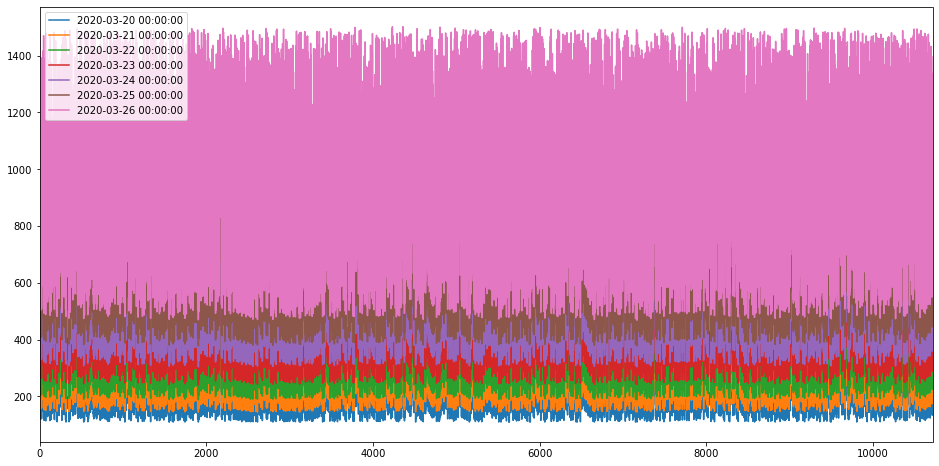

In [10]:
# infections vs date
# y-axis - number of infections
# x-axis - people_ID
train_copy.plot(figsize=(16, 8));

In [11]:
## infection rate is high on 26th March 

In [12]:
# density plot
train_copy.plot(kind="kde", figsize=(16, 8));

In [13]:
train_copy.plot(kind="hist", figsize=(16, 8));

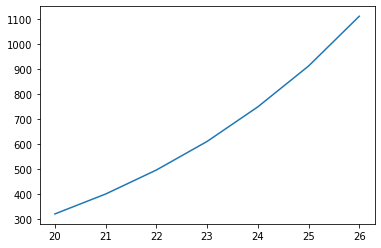

In [14]:
# #infections vs date for a single people_ID
plt.plot([col.date().day for col in cols], train_copy.values[np.random.randint(0, train_copy.values.shape[1])]);

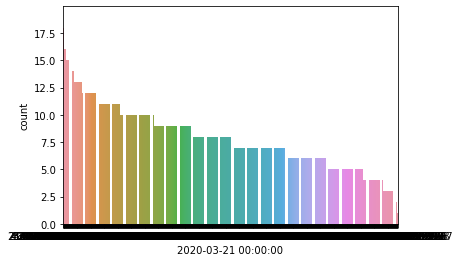

In [15]:
# infections counts for diff p_ids in a day
sns.countplot(x = cols[1], data = train_copy, order = train_copy[cols[1]].value_counts().index);

In [16]:
train_df.head()

people_ID  2020-03-20 00:00:00  2020-03-21 00:00:00  2020-03-22 00:00:00  \
0          1                  441                544.2               669.64   
1          2                  151                197.2               253.24   
2          3                  416                515.2               632.44   
3          4                  410                506.0               621.40   
4          5                  390                483.0               595.00   

   2020-03-23 00:00:00  2020-03-24 00:00:00  2020-03-25 00:00:00  \
0              821.368            1002.2416           1215.68992   
1              321.688             399.9256            492.91072   
2              776.728             947.7736           1150.32832   
3              761.880             928.1560           1126.78720   
4              730.200             892.8400           1084.40800   

   2020-03-26 00:00:00  
0          1472.627904  
1           606.892864  
2          1395.793984  
3          1368.344640  
4          1315.889600

In [17]:
train_transpose = train_copy.transpose()

In [18]:
train_transpose.head()

0         1         2        3       4         5      \
2020-03-20 00:00:00   441.0000  151.0000  416.0000  410.000  390.00  389.0000   
2020-03-21 00:00:00   544.2000  197.2000  515.2000  506.000  483.00  480.8000   
2020-03-22 00:00:00   669.6400  253.2400  632.4400  621.400  595.00  591.1600   
2020-03-23 00:00:00   821.3680  321.6880  776.7280  761.880  730.20  723.9920   
2020-03-24 00:00:00  1002.2416  399.9256  947.7736  928.156  892.84  882.6904   

                        6         7        8         9      ...     10704  \
2020-03-20 00:00:00  322.0000  194.0000  310.000  242.0000  ...  339.0000   
2020-03-21 00:00:00  401.4000  246.8000  385.000  303.4000  ...  420.8000   
2020-03-22 00:00:00  497.0800  310.3600  477.400  379.4800  ...  519.1600   
2020-03-23 00:00:00  611.0960  388.6320  589.080  469.9760  ...  639.1920   
2020-03-24 00:00:00  749.0152  482.9584  720.796  578.7712  ...  780.9304   

                        10705     10706     10707     10708     10709  \
2020-03-20 00:00:00  241.0000  183.0000  297.0000  397.0000  134.0000   
2020-03-21 00:00:00  305.2000  232.6000  370.4000  489.4000  173.8000   
2020-03-22 00:00:00  382.8400  293.3200  459.8800  603.8800  225.1600   
2020-03-23 00:00:00  477.2080  368.1840  568.0560  742.4560  287.9920   
2020-03-24 00:00:00  588.3496  458.4208  698.2672  906.6472  359.4904   

                        10710     10711     10712     10713  
2020-03-20 00:00:00  387.0000  177.0000  352.0000  181.0000  
2020-03-21 00:00:00  479.4000  228.4000  438.4000  230.2000  
2020-03-22 00:00:00  591.8800  288.2800  542.6800  290.4400  
2020-03-23 00:00:00  724.8560  362.1360  665.8160  366.3280  
2020-03-24 00:00:00  884.6272  448.4632  814.6792  455.2936  

[5 rows x 10714 columns]

In [19]:
train_transpose[0]

2020-03-20     441.000000
2020-03-21     544.200000
2020-03-22     669.640000
2020-03-23     821.368000
2020-03-24    1002.241600
2020-03-25    1215.689920
2020-03-26    1472.627904
Name: 0, dtype: float64

In [22]:
cols_date = [datetime for col in cols]

In [23]:
date_df = pd.DataFrame(cols_date, columns=['date'])

In [24]:
train_transpose = train_copy.transpose()

In [25]:
train_transpose.head()

0         1         2        3       4         5      \
2020-03-20 00:00:00   441.0000  151.0000  416.0000  410.000  390.00  389.0000   
2020-03-21 00:00:00   544.2000  197.2000  515.2000  506.000  483.00  480.8000   
2020-03-22 00:00:00   669.6400  253.2400  632.4400  621.400  595.00  591.1600   
2020-03-23 00:00:00   821.3680  321.6880  776.7280  761.880  730.20  723.9920   
2020-03-24 00:00:00  1002.2416  399.9256  947.7736  928.156  892.84  882.6904   

                        6         7        8         9      ...     10704  \
2020-03-20 00:00:00  322.0000  194.0000  310.000  242.0000  ...  339.0000   
2020-03-21 00:00:00  401.4000  246.8000  385.000  303.4000  ...  420.8000   
2020-03-22 00:00:00  497.0800  310.3600  477.400  379.4800  ...  519.1600   
2020-03-23 00:00:00  611.0960  388.6320  589.080  469.9760  ...  639.1920   
2020-03-24 00:00:00  749.0152  482.9584  720.796  578.7712  ...  780.9304   

                        10705     10706     10707     10708     10709  \
2020-03-20 00:00:00  241.0000  183.0000  297.0000  397.0000  134.0000   
2020-03-21 00:00:00  305.2000  232.6000  370.4000  489.4000  173.8000   
2020-03-22 00:00:00  382.8400  293.3200  459.8800  603.8800  225.1600   
2020-03-23 00:00:00  477.2080  368.1840  568.0560  742.4560  287.9920   
2020-03-24 00:00:00  588.3496  458.4208  698.2672  906.6472  359.4904   

                        10710     10711     10712     10713  
2020-03-20 00:00:00  387.0000  177.0000  352.0000  181.0000  
2020-03-21 00:00:00  479.4000  228.4000  438.4000  230.2000  
2020-03-22 00:00:00  591.8800  288.2800  542.6800  290.4400  
2020-03-23 00:00:00  724.8560  362.1360  665.8160  366.3280  
2020-03-24 00:00:00  884.6272  448.4632  814.6792  455.2936  

[5 rows x 10714 columns]

In [26]:
# train_transpose

In [27]:
# set the index as date 
train_transpose['date'] = train_transpose.index

In [28]:
train_transpose.head()

0         1         2        3       4         5  \
2020-03-20 00:00:00   441.0000  151.0000  416.0000  410.000  390.00  389.0000   
2020-03-21 00:00:00   544.2000  197.2000  515.2000  506.000  483.00  480.8000   
2020-03-22 00:00:00   669.6400  253.2400  632.4400  621.400  595.00  591.1600   
2020-03-23 00:00:00   821.3680  321.6880  776.7280  761.880  730.20  723.9920   
2020-03-24 00:00:00  1002.2416  399.9256  947.7736  928.156  892.84  882.6904   

                            6         7        8         9  ...     10705  \
2020-03-20 00:00:00  322.0000  194.0000  310.000  242.0000  ...  241.0000   
2020-03-21 00:00:00  401.4000  246.8000  385.000  303.4000  ...  305.2000   
2020-03-22 00:00:00  497.0800  310.3600  477.400  379.4800  ...  382.8400   
2020-03-23 00:00:00  611.0960  388.6320  589.080  469.9760  ...  477.2080   
2020-03-24 00:00:00  749.0152  482.9584  720.796  578.7712  ...  588.3496   

                        10706     10707     10708     10709     10710  \
2020-03-20 00:00:00  183.0000  297.0000  397.0000  134.0000  387.0000   
2020-03-21 00:00:00  232.6000  370.4000  489.4000  173.8000  479.4000   
2020-03-22 00:00:00  293.3200  459.8800  603.8800  225.1600  591.8800   
2020-03-23 00:00:00  368.1840  568.0560  742.4560  287.9920  724.8560   
2020-03-24 00:00:00  458.4208  698.2672  906.6472  359.4904  884.6272   

                        10711     10712     10713       date  
2020-03-20 00:00:00  177.0000  352.0000  181.0000 2020-03-20  
2020-03-21 00:00:00  228.4000  438.4000  230.2000 2020-03-21  
2020-03-22 00:00:00  288.2800  542.6800  290.4400 2020-03-22  
2020-03-23 00:00:00  362.1360  665.8160  366.3280 2020-03-23  
2020-03-24 00:00:00  448.4632  814.6792  455.2936 2020-03-24  

[5 rows x 10715 columns]

In [29]:
# since we have date as index we no longer need index
train_transpose = train_transpose.reset_index(drop=True)

In [30]:
train_transpose.head()

0         1         2        3       4         5         6  \
0   441.0000  151.0000  416.0000  410.000  390.00  389.0000  322.0000   
1   544.2000  197.2000  515.2000  506.000  483.00  480.8000  401.4000   
2   669.6400  253.2400  632.4400  621.400  595.00  591.1600  497.0800   
3   821.3680  321.6880  776.7280  761.880  730.20  723.9920  611.0960   
4  1002.2416  399.9256  947.7736  928.156  892.84  882.6904  749.0152   

          7        8         9  ...     10705     10706     10707     10708  \
0  194.0000  310.000  242.0000  ...  241.0000  183.0000  297.0000  397.0000   
1  246.8000  385.000  303.4000  ...  305.2000  232.6000  370.4000  489.4000   
2  310.3600  477.400  379.4800  ...  382.8400  293.3200  459.8800  603.8800   
3  388.6320  589.080  469.9760  ...  477.2080  368.1840  568.0560  742.4560   
4  482.9584  720.796  578.7712  ...  588.3496  458.4208  698.2672  906.6472   

      10709     10710     10711     10712     10713       date  
0  134.0000  387.0000  177.0000  352.0000  181.0000 2020-03-20  
1  173.8000  479.4000  228.4000  438.4000  230.2000 2020-03-21  
2  225.1600  591.8800  288.2800  542.6800  290.4400 2020-03-22  
3  287.9920  724.8560  362.1360  665.8160  366.3280 2020-03-23  
4  359.4904  884.6272  448.4632  814.6792  455.2936 2020-03-24  

[5 rows x 10715 columns]

In [31]:
train_transpose = train_transpose.set_index(train_transpose.date)

In [32]:
train_transpose.head()

0         1         2        3       4         5  \
date                                                                   
2020-03-20   441.0000  151.0000  416.0000  410.000  390.00  389.0000   
2020-03-21   544.2000  197.2000  515.2000  506.000  483.00  480.8000   
2020-03-22   669.6400  253.2400  632.4400  621.400  595.00  591.1600   
2020-03-23   821.3680  321.6880  776.7280  761.880  730.20  723.9920   
2020-03-24  1002.2416  399.9256  947.7736  928.156  892.84  882.6904   

                   6         7        8         9  ...     10705     10706  \
date                                               ...                       
2020-03-20  322.0000  194.0000  310.000  242.0000  ...  241.0000  183.0000   
2020-03-21  401.4000  246.8000  385.000  303.4000  ...  305.2000  232.6000   
2020-03-22  497.0800  310.3600  477.400  379.4800  ...  382.8400  293.3200   
2020-03-23  611.0960  388.6320  589.080  469.9760  ...  477.2080  368.1840   
2020-03-24  749.0152  482.9584  720.796  578.7712  ...  588.3496  458.4208   

               10707     10708     10709     10710     10711     10712  \
date                                                                     
2020-03-20  297.0000  397.0000  134.0000  387.0000  177.0000  352.0000   
2020-03-21  370.4000  489.4000  173.8000  479.4000  228.4000  438.4000   
2020-03-22  459.8800  603.8800  225.1600  591.8800  288.2800  542.6800   
2020-03-23  568.0560  742.4560  287.9920  724.8560  362.1360  665.8160   
2020-03-24  698.2672  906.6472  359.4904  884.6272  448.4632  814.6792   

               10713       date  
date                             
2020-03-20  181.0000 2020-03-20  
2020-03-21  230.2000 2020-03-21  
2020-03-22  290.4400 2020-03-22  
2020-03-23  366.3280 2020-03-23  
2020-03-24  455.2936 2020-03-24  

[5 rows x 10715 columns]

In [33]:
train_transpose_copy = train_transpose.drop(columns=['date'], axis=1)

In [34]:
train_transpose_copy

0           1            2           3          4      \
date                                                                      
2020-03-20   441.000000  151.000000   416.000000   410.00000   390.0000   
2020-03-21   544.200000  197.200000   515.200000   506.00000   483.0000   
2020-03-22   669.640000  253.240000   632.440000   621.40000   595.0000   
2020-03-23   821.368000  321.688000   776.728000   761.88000   730.2000   
2020-03-24  1002.241600  399.925600   947.773600   928.15600   892.8400   
2020-03-25  1215.689920  492.910720  1150.328320  1126.78720  1084.4080   
2020-03-26  1472.627904  606.892864  1395.793984  1368.34464  1315.8896   

                  5            6           7           8           9      ...  \
date                                                                      ...   
2020-03-20   389.000000   322.000000  194.000000   310.00000  242.000000  ...   
2020-03-21   480.800000   401.400000  246.800000   385.00000  303.400000  ...   
2020-03-22   591.160000   497.080000  310.360000   477.40000  379.480000  ...   
2020-03-23   723.992000   611.096000  388.632000   589.08000  469.976000  ...   
2020-03-24   882.690400   749.015200  482.958400   720.79600  578.771200  ...   
2020-03-25  1072.228480   911.818240  592.550080   877.95520  707.525440  ...   
2020-03-26  1301.274176  1110.381888  724.860096  1069.74624  865.230528  ...   

                  10704       10705       10706        10707        10708  \
date                                                                        
2020-03-20   339.000000  241.000000  183.000000   297.000000   397.000000   
2020-03-21   420.800000  305.200000  232.600000   370.400000   489.400000   
2020-03-22   519.160000  382.840000  293.320000   459.880000   603.880000   
2020-03-23   639.192000  477.208000  368.184000   568.056000   742.456000   
2020-03-24   780.930400  588.349600  458.420800   698.267200   906.647200   
2020-03-25   950.116480  719.019520  563.104960   850.920640  1100.976640   
2020-03-26  1153.939776  878.223424  690.325952  1034.904768  1337.371968   

                 10709        10710       10711        10712       10713  
date                                                                      
2020-03-20  134.000000   387.000000  177.000000   352.000000  181.000000  
2020-03-21  173.800000   479.400000  228.400000   438.400000  230.200000  
2020-03-22  225.160000   591.880000  288.280000   542.680000  290.440000  
2020-03-23  287.992000   724.856000  362.136000   665.816000  366.328000  
2020-03-24  359.490400   884.627200  448.463200   814.679200  455.293600  
2020-03-25  444.388480  1074.552640  551.155840   990.615040  559.352320  
2020-03-26  549.466176  1303.263168  676.787008  1204.138048  686.622784  

[7 rows x 10714 columns]

In [35]:
train, test = train_transpose_copy[:6], train_transpose_copy[6:]

In [36]:
test.shape

(1, 10714)

### Scaling the data(It will help to converge faster)

In [37]:
scaler = MinMaxScaler()

In [38]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [39]:
train = scaler.transform(train)
test = scaler.transform(test)

In [40]:
n_input = 1
n_features = train.shape[1]

In [41]:
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

In [42]:
# TimeseriesGenerator?
# X[0].shape

## LSTM Model for Time Series Prediction

In [43]:
def create_model():
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(1, 10714)))
    model.add(Dropout(0.15))
    model.add(Dense(train.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    return model

In [50]:
model = create_model()

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               8732000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10714)             2153514   
Total params: 10,885,514
Trainable params: 10,885,514
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.fit_generator(generator, epochs=90)

Epoch 1/90
5/5 [==============================] - 1s 182ms/step - loss: 0.4131
Epoch 2/90
5/5 [==============================] - 0s 67ms/step - loss: 0.2146
Epoch 3/90
5/5 [==============================] - 0s 64ms/step - loss: 0.1561
Epoch 4/90
5/5 [==============================] - 0s 62ms/step - loss: 0.1304
Epoch 5/90
5/5 [==============================] - 0s 62ms/step - loss: 0.1598
Epoch 6/90
5/5 [==============================] - 0s 65ms/step - loss: 0.1657
Epoch 7/90
5/5 [==============================] - 0s 65ms/step - loss: 0.0830
Epoch 8/90
5/5 [==============================] - 0s 66ms/step - loss: 0.0727
Epoch 9/90
5/5 [==============================] - 0s 65ms/step - loss: 0.0425
Epoch 10/90
5/5 [==============================] - 0s 69ms/step - loss: 0.0308
Epoch 11/90
5/5 [==============================] - 0s 64ms/step - loss: 0.0304
Epoch 12/90
5/5 [==============================] - 0s 75ms/step - loss: 0.0236
Epoch 13/90
5/5 [==============================] - 0s 73ms/s

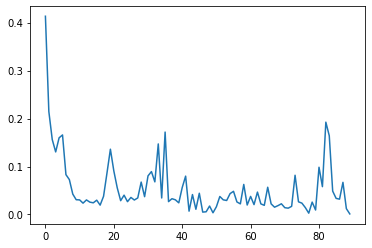

In [54]:
# Loss Plot
plt.plot(model.history.history['loss']);

# Inference

In [58]:
## reshaping the test data 
test_copy = test.reshape((1, 1, test.shape[1]))

In [60]:
preds  = model.predict(test_copy)

In [61]:
preds_scaled = scaler.inverse_transform(preds)

In [62]:
preds_scaled.shape

(1, 10714)

In [63]:
results = np.transpose(preds_scaled)

In [64]:
# results = results.squeeze()

In [65]:
print(f'results and people_ID shape should be equal = {results.shape == people_ID.shape}')

results and people_ID shape should be equal = False


In [66]:
results_df = pd.DataFrame(data=results, columns = ["2020-03-27"])

## Cobine the new pred with original data and plot to see the infection rate

In [70]:
new_train = pd.concat([train_copy, results_df], axis=1)

In [73]:
new_train.plot(figsize=(16, 8))
plt.show()

### From the above plot we can say that infections on 27-03-2020 is going to be much higher than the previous dates which is unfotunate

#### Desnity plot 

In [75]:
covid19_time_series = pd.concat([train_df.people_ID, results_df], axis=1)

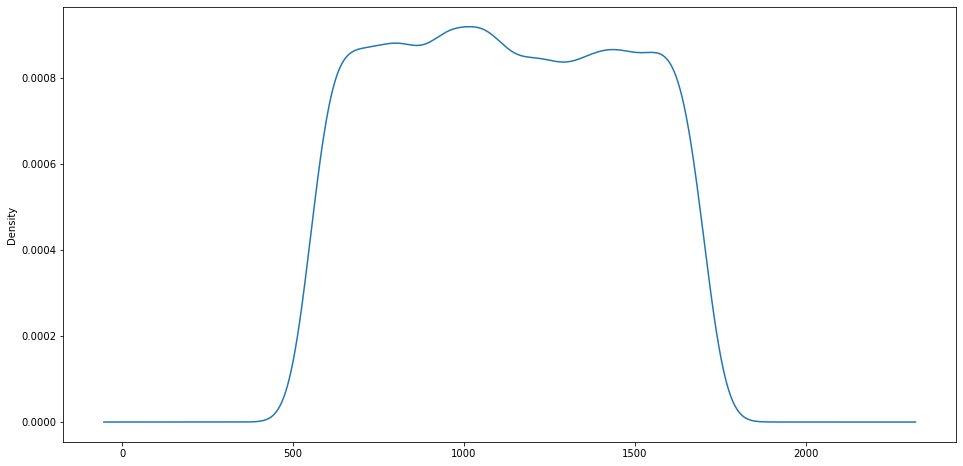

In [76]:
covid19_time_series["2020-03-27"].plot(kind="kde", figsize=(16, 8));

### Save the predictions files into csv file for submission

In [150]:
covid19_time_series.head()

people_ID   2020-03-27
0          1  1650.297607
1          2   676.872498
2          3  1551.860962
3          4  1497.703613
4          5  1450.746826

In [ ]:
covid19_time_series.to_csv("covid19_time_series.csv", index=None)